# Homework #2
* Given the technology parameters of our 180 nm CMOS process, take a device of $W / L = 1.0 \ / \ 0.18 \ \mu\text{m}$. Simulate, print and plot $I_\mathrm{D}$ vs. $V_\mathrm{g}$ for a range of $V_\mathrm{g}$.
* Read [this paper](https://www.researchgate.net/publication/220456459_A_review_of_recent_MOSFET_threshold_voltage_extraction_methods) and write a program to extract the value of the threshold voltage $V_\mathrm{T}$ using the methods explained in the paper in the paragraphs 2.1 and 2.2.

## Import

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

## Useful functions

In [5]:
# define ticks
def set_ticks(ax, xMaj, xMin, yMaj, yMin):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.xaxis.set_minor_locator(AutoMinorLocator(xMin))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.yaxis.set_minor_locator(AutoMinorLocator(yMin))
    ax.tick_params(which='major', right=False, width=1.0, length=8, direction="in", labelsize=12)
    ax.tick_params(which='minor', right=False, width=1.0, length=4, direction="in", labelsize=12)

def set_ticks_x(ax, xMaj, xMin):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.xaxis.set_minor_locator(AutoMinorLocator(xMin))
    ax.tick_params(which='major', right=True, width=1.0, length=8, direction="in", labelsize=12)
    ax.tick_params(which='minor', right=True, width=1.0, length=4, direction="in", labelsize=12)

def set_ticks_y(ax, yMaj, yMin):
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.yaxis.set_minor_locator(AutoMinorLocator(yMin))
    ax.tick_params(which='major', right=True, width=1.0, length=8, direction="in", labelsize=12)
    ax.tick_params(which='minor', right=True, width=1.0, length=4, direction="in", labelsize=12)

# linear function
def linear(x, a, b):
    return a + b * x

# find nearest value in array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [6]:
# width and length expressed in [m]
w = 1e-6
l = 180e-9

# arbitrary constant drain current [A]
c_i = (w / l) * 1e-7

## Analysis

* **Constant Current** (CC) method. Fix the arbitrary constant drain current found as $\overline{\mathrm{I}}_\mathrm{D} = W / L * 10^{-7}$ and find the corresponding $V_\mathrm{g}$ value from the $I_\mathrm{D}(V_\mathrm{g})$ curve found from the LTspice simulation. It holds: $W / L * 10^{-7} = I_\mathrm{D}(V_\mathrm{g} = V_\mathrm{T})$.
* **Extrapolation in the Linear Region** (ELR) method. Firstly, the intersection gate voltage $V_\mathrm{int}$ between the $x$-axis and the linear fit around the maximum slope regione of the $I_\mathrm{D}(V_\mathrm{g})$ curve is found. Therefore, the threshold voltage is $V_\mathrm{T} = V_\mathrm{int} + V_\mathrm{D} / 2$. \
Note that the LTspice simulation was carried out with $V_\mathrm{D} = 500 \ \text{mV}$.

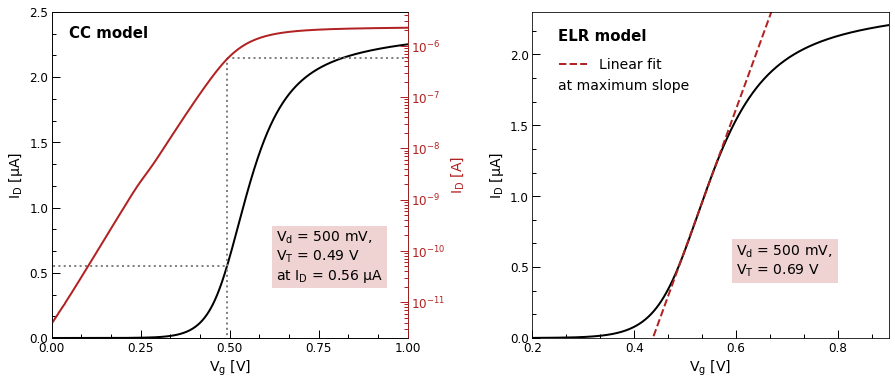

In [278]:
# data
filename = "current.txt"

# unpack data
v_g, i_d = np.loadtxt(filename, unpack=True)

# plot layout
fig, (ax, ax1) = plt.subplots(figsize=(15,6), ncols=2, nrows=1, gridspec_kw={'hspace': 0.1, 'wspace': 0.35})

# plot
ax.plot(v_g, i_d * 1e6, color='black', alpha=1, lw=2)

'''
    CC method.
'''

# find the approximate v_th for c_i
index, _ = find_nearest(i_d, c_i)
v_th = v_g[int(index)]

# show results
ax.hlines(c_i * 1e6, xmin=-0.1, xmax=v_th, color='gray', lw=2, ls=":", alpha=1)
ax.vlines(v_th, ymin=-0.1, ymax=2.15, color='gray', lw=2, ls=":", alpha=1)
ax.hlines(2.15, xmin=v_th, xmax=1, color='gray', lw=2, ls=":", alpha=1)

# print results on screen
i = c_i * 1e6
ax.text(0.63, 0.45, "V$_{\mathrm{d}}$ = 500 mV, \nV$_{\mathrm{T}}$ = %.2f V \nat I$_\mathrm{D}$ = %.2f $\mathrm{\mu}$A" % (v_th, i), fontsize=14, 
        bbox=dict(facecolor='firebrick', alpha=0.2, edgecolor='none'))
ax.text(0.05, 2.3, "CC model", fontsize=15, fontweight='bold')

# labels
ax.set_xlabel("V$_{\mathrm{g}}$ [V]", fontsize=14)
ax.set_ylabel("I$_\mathrm{D}$ [$\mathrm{\mu}$A]", fontsize=14)

# second plot
ax2 = ax.twinx()
ax2.plot(v_g, i_d, color='firebrick', alpha=1, lw=2)
set_ticks_y(ax2, 10, 10)
ax2.set_yscale('log')
ax2.set_ylabel("I$_\mathrm{D}$ [A]", fontsize=14)

# highlight axis
ax2.spines['right'].set_color('firebrick')
ax2.yaxis.label.set_color('firebrick') 
ax2.tick_params(axis='y', which='both', colors='firebrick')

# range
ax.set_xlim(0, 1)
ax.set_ylim(0, 2.5)

# ticks
set_ticks(ax, 0.25, 3, 0.5, 3)

'''
    ELR method.
'''

# plot
ax1.plot(v_g, i_d * 1e6, color='black', alpha=1, lw=2)

# fit in the range v = [0.51, 0.57] V
v_tofit, i_tofit = [], []
for v, i in zip(v_g, i_d):
    if v > 0.51 and v < 0.57:
        v_tofit.append(v)
        i_tofit.append(i*1e6)
slope, intercept, _, _, _ = stats.linregress(v_tofit, i_tofit, alternative='greater')
domain = np.linspace(0.2, 0.8, 100)
ax1.plot(domain, linear(domain, intercept, slope), lw=2, ls='--', c='firebrick', label='Linear fit')

# find voltage as intersection + V_d / 2
intersection = - intercept / slope
v_th_ext = intersection + 0.5 / 2

# print results on screen
i = c_i * 1e6
ax1.text(0.6, 0.45, "V$_{\mathrm{d}}$ = 500 mV, \nV$_{\mathrm{T}}$ = %.2f V" % (v_th_ext), fontsize=14, 
        bbox=dict(facecolor='firebrick', alpha=0.2, edgecolor='none'))
ax1.text(0.25, 2.1, "ELR model", fontsize=15, fontweight='bold')

# range
ax1.set_xlim(0.2, 0.9)
ax1.set_ylim(0, 2.3)

# labels
ax1.set_xlabel("V$_{\mathrm{g}}$ [V]", fontsize=14)
ax1.set_ylabel("I$_\mathrm{D}$ [$\mathrm{\mu}$A]", fontsize=14)
ax1.legend(loc=(0.06, 0.8), frameon=False, fontsize=14)
ax1.text(0.25, 1.75, "at maximum slope", fontsize=14)

# ticks
set_ticks(ax1, 0.2, 3, 0.5, 3)

# save
fig.savefig("analysis.pdf")